## Import relevant python modules and data handling

In [1]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
from pandas import DataFrame
import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
from matplotlib import pyplot
import rasterio
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
#from digitalearthau.utils import wofs_fuser
sys.path.append('../10_Scripts/')
#import DEAPlotting, DEADataHandling
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

## Enter name of the depth gauge file

In [2]:
csv = 'Tantangara.csv'
pd.read_csv(csv, skiprows=9)

,#Timestamp,Value,Interpolation Type,Quality Code
0,1998-10-08T00:00:00.000+10:00,NaN,603,-1
1,1998-10-09T00:00:00.000+10:00,NaN,603,-1
2,1998-10-10T00:00:00.000+10:00,NaN,603,-1
3,1998-10-11T00:00:00.000+10:00,NaN,603,-1
4,1998-10-12T00:00:00.000+10:00,NaN,603,-1
...,...,...,...,...
7938,2020-07-02T00:00:00.000+10:00,1211.576,603,10
7939,2020-07-03T00:00:00.000+10:00,1211.563,603,10
7940,2020-07-04T00:00:00.000+10:00,1211.541,603,10
7941,2020-07-05T00:00:00.000+10:00,1211.520,603,10


## Automatically obtain the location info for the satellite data query

In [3]:
#Get the name and ID of the gauge so you can get the centroid of the reservoir from the join_matched shapefile
gauge_number_df = pd.read_csv(csv, nrows=1, escapechar='#')
column2 = list(gauge_number_df)[1]
gauge_number_df = gauge_number_df.rename(columns = {column2 : 'gauge_ID'})
ID = gauge_number_df.at[0, 'gauge_ID']
ID_str = ID.astype(str)
gauge_name_df = pd.read_csv(csv, nrows=2, escapechar='#')
name = list(gauge_name_df)[1]
area_lookup = pd.read_csv('../ID_area_lookup')
area_lookup = area_lookup.set_index('gauge_ID')
area = area_lookup.at[ID_str, 'Area_calc'].max()

buffer_factor = 2848.12 #I decided this number because 7000 was a good buffer for Tantangara. Use this number for all reservoirs.
ID_area = pd.read_csv('../ID_area_lookup')
ID_area['buffer'] = ID_area['Area_calc']/buffer_factor
ID_area = ID_area.set_index(['gauge_ID'])
buffer = ID_area.at[ID_str, 'buffer']
buffer = buffer.max()

loc_lookup = pd.read_csv('../gauge_lookup_table')
loc_lookup = loc_lookup.set_index(['gauge_ID'])

lat = loc_lookup.at[ID_str, 'lat']
lon = loc_lookup.at[ID_str, 'lon']

surface_area = ID_area.at[ID_str, 'Area_calc']
area = surface_area.max()

print('The recommended buffer is:', buffer)
print('the location of the middle of the reservoir is:', lat, lon)
print('gauge name:', name)
print('gauge ID:', ID_str)
print('The area as calculated from the polygon:', area)

The recommended buffer is: 7000.005617740826
the location of the middle of the reservoir is: -35.745842844869095 148.6591187125928
gauge name: Murrumbidgee River at Tantangara Reservoir
gauge ID: 410543
The area as calculated from the polygon: 19936856.0


## Organise data by depth (instead of time) and split into 1m intervals

there are this many 1 meter intervals for depth: 20


Text(0.5, 1.0, 'Depth duration curve: how much % of time the depth was at least this high.')

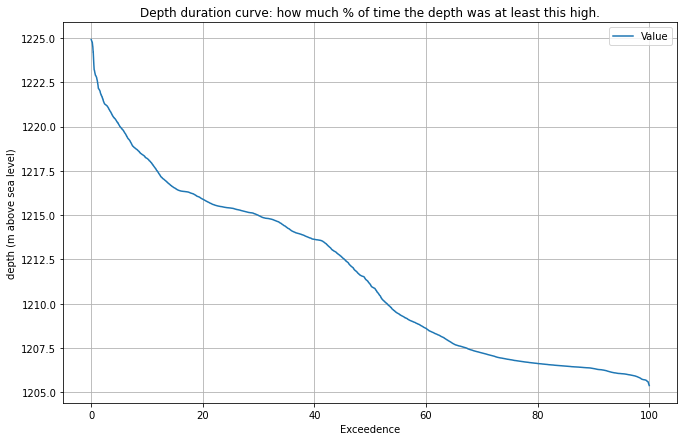

In [4]:
#Make depth duration curve
gauge_data = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#',
                         parse_dates=['Timestamp'], 
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0])) #Robbi wrote this line
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns=['Interpolation Type', 'Quality Code'])

#Get the depth range and intervals
depth_integers = gauge_data.astype(np.int64)
max_depth = depth_integers.Value.max()
min_depth = depth_integers.Value.min()
integer_array = depth_integers.Value.unique()
integer_list = integer_array.tolist()

print('there are this many 1 meter intervals for depth:', len(integer_list))
gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7))
plt.ylabel('depth (m above sea level)')
plt.grid(True)
plt.title('Depth duration curve: how much % of time the depth was at least this high.')

## Link satellite data with the stream gauge data

In [5]:
#Dask loading wofs_albers data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1980-01-01', '2019-08-22'), 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)
gauge_data_xr = gauge_data.to_xarray()
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time)

## Loop load data for each 1m of depth

This is the area as calculated from wet pixels at 1205 meters 2413125
This is the area as calculated from wet pixels at 1206 meters 2778125
This is the area as calculated from wet pixels at 1207 meters 3143125
This is the area as calculated from wet pixels at 1208 meters 3722500
This is the area as calculated from wet pixels at 1209 meters 4056250
This is the area as calculated from wet pixels at 1210 meters 4576875
This is the area as calculated from wet pixels at 1211 meters 4888125
This is the area as calculated from wet pixels at 1212 meters 5372500
This is the area as calculated from wet pixels at 1213 meters 5885625
This is the area as calculated from wet pixels at 1214 meters 6353125
This is the area as calculated from wet pixels at 1215 meters 6725000
This is the area as calculated from wet pixels at 1216 meters 7169375
This is the area as calculated from wet pixels at 1217 meters 7971875
This is the area as calculated from wet pixels at 1218 meters 8772500
This is the area as 

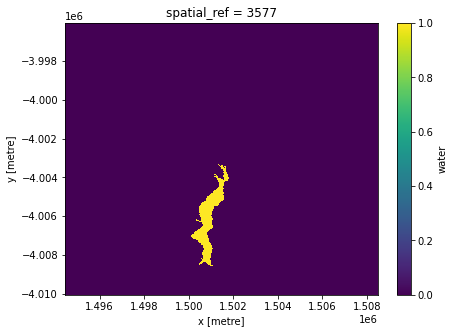

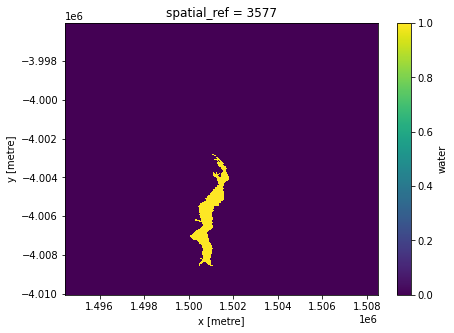

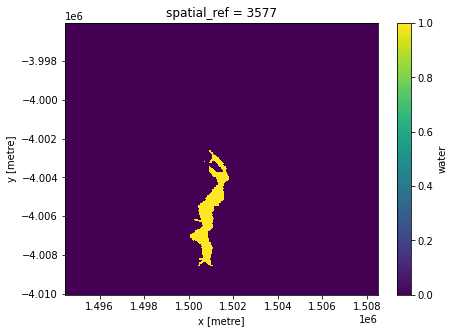

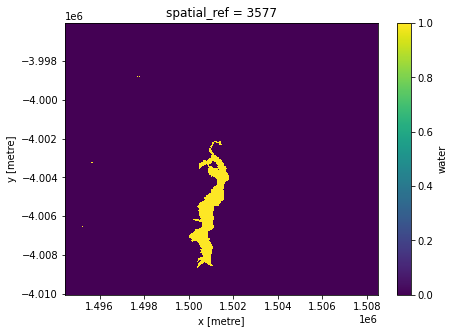

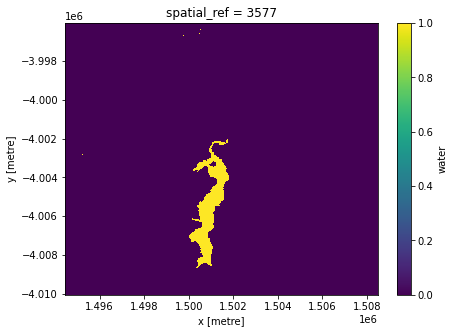

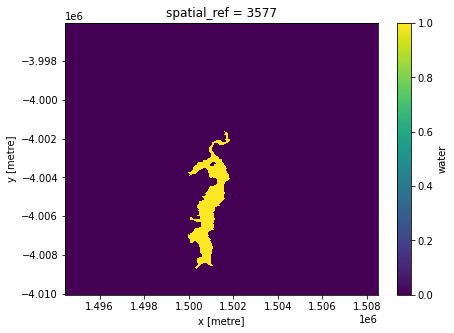

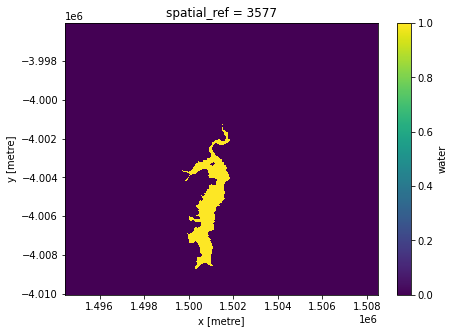

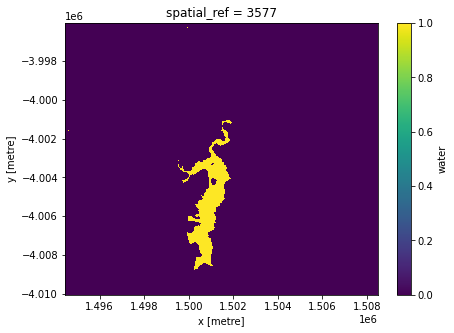

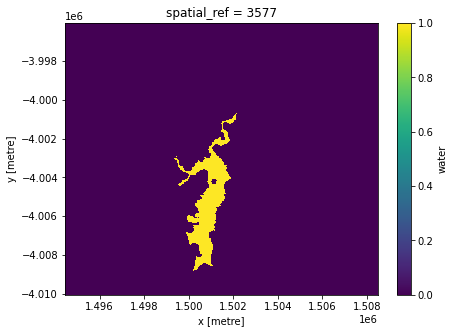

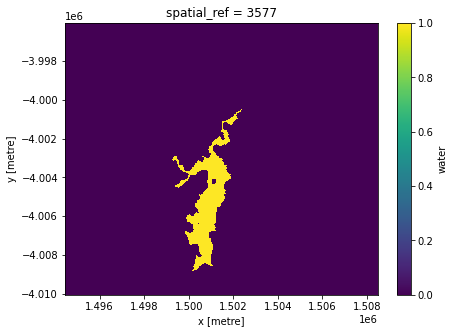

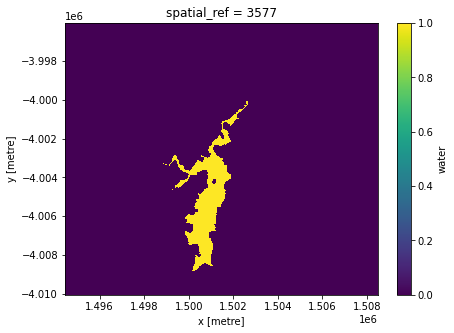

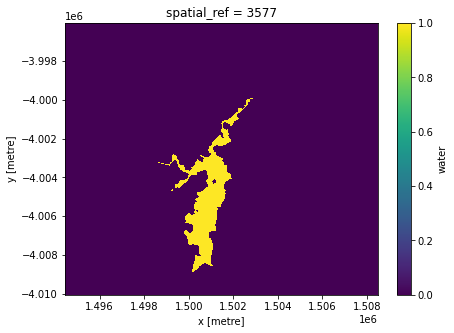

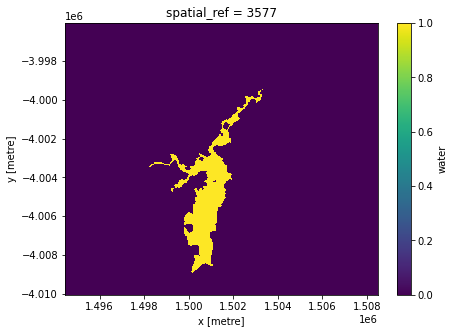

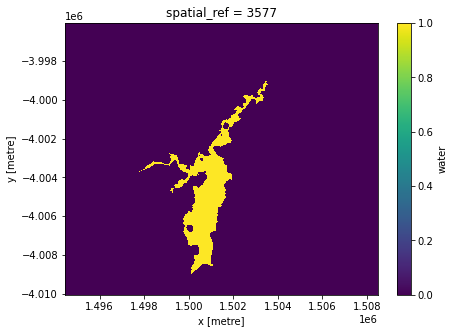

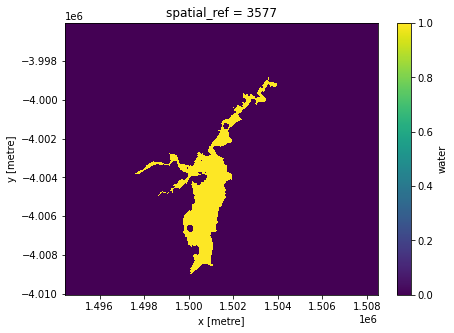

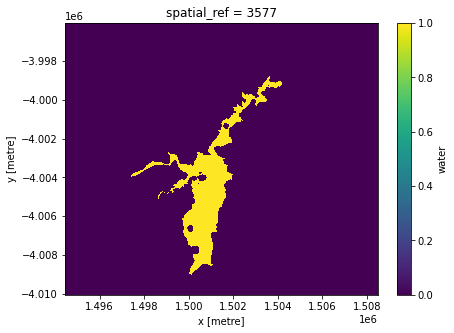

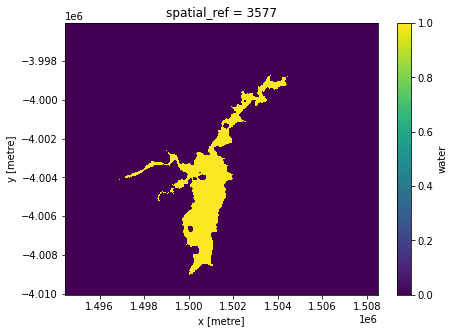

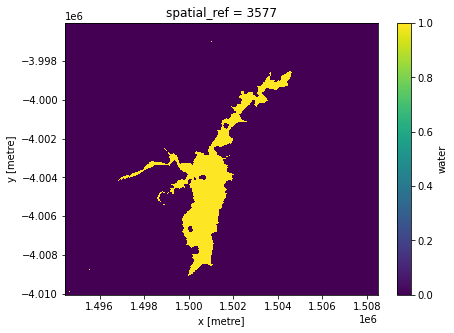

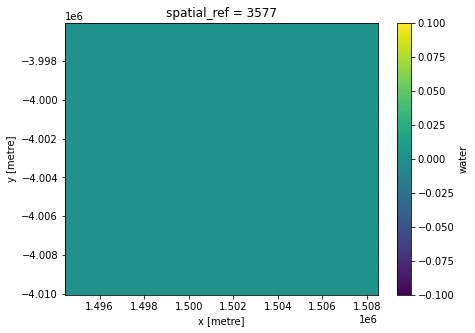

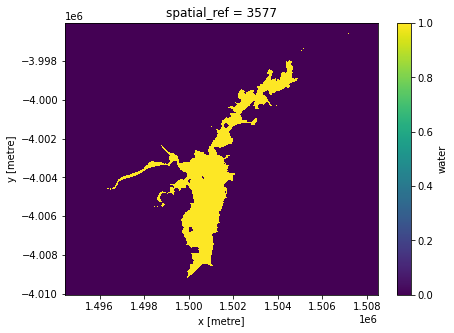

In [6]:
surface_area_list = []

for i in integer_list:
    specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+1), drop=True)
    date_list = specified_level.time.values
    specified_passes = wofs_albers.sel(time=date_list).compute()
    #cloudmask
    cc = masking.make_mask(specified_passes.water, cloud=True)
    ncloud_pixels = cc.sum(dim=['x', 'y'])
    # Calculate the total number of pixels per timestep
    npixels_per_slice = (specified_passes.water.shape[1] * 
                         specified_passes.water.shape[2])
    cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
    clear_specified_passes = specified_passes.water.isel(
        time=cloud_pixels_fraction < 0.2)
    wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim='time')
    dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim='time')
    clear = wet + dry
    frequency = wet / clear
    frequency = frequency.fillna(0)  
   
    #Get area from the satellite data
    #get the frequency array
    frequency_array = frequency.values
    #Turn any pixel in the frequency array with a value greater than 0.2 into a pixel of value 1
    #if the pixel value is 0.2 or lower it gets value 0
    is_water = np.where((frequency_array > 0.2),1,0)
    #give the 'frequency' xarray back its new values of zero and one
    frequency.values = is_water
    #sum up the pixels
    number_water_pixels = frequency.sum(dim=['x', 'y'])
    #get the number
    number_water_pixels = number_water_pixels.values.tolist()
    #multiply by pixel size to get area in m2
    area_m2 = number_water_pixels*(25*25)
    
    surface_area_list.append(area_m2)
    print('This is the area as calculated from wet pixels at', i, 'meters', area_m2)

    #Plotting the image
    frequency.plot(figsize = (7,5))

## Fix zero values (by cheating, sorry will fix later)

In [9]:
new_surface_area_list = [i if i > 0 else 12446875 for i in surface_area_list] #this is cheating. Fix it. 
new_surface_area_list

[2413125,
 2778125,
 3143125,
 3722500,
 4056250,
 4576875,
 4888125,
 5372500,
 5885625,
 6353125,
 6725000,
 7169375,
 7971875,
 8772500,
 9557500,
 10153750,
 10800625,
 11535625,
 12446875,
 13358125]

## Make a table of what the surface area is for each depth interval (depth to surface area lookup table)

## Hydrograph to monthly surface area
The hydrograph is depth over time. We can use the table we just made to get surface area over time

This is the original hydrograph: depth over time


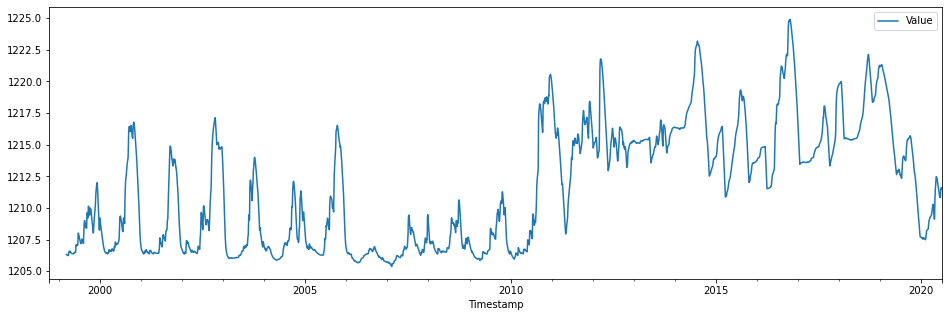

In [7]:
orig_hydrograph = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#',
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'), #Tells it to set Timestamp as the index column
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0])) #turns timestamp into date
orig_hydrograph = orig_hydrograph.drop(columns=['Interpolation Type', 'Quality Code'])
orig_hydrograph.plot(figsize=(16, 5))
print('This is the original hydrograph: depth over time')

In [10]:
#create dataframe of depth to surface area 
depth_to_area_df = DataFrame(integer_list, columns=['Depth'])
depth_to_area_df['Name'] = name
depth_to_area_df['Gauge ID']= ID_str
depth_to_area_df['Surface Area'] = new_surface_area_list
depth_to_area_df = depth_to_area_df[['Gauge ID', 'Name', 'Depth', 'Surface Area']]

depth_to_area_df

,Gauge ID,Name,Depth,Surface Area
0,410543,Murrumbidgee River at Tantangara Reservoir,1205,2413125
1,410543,Murrumbidgee River at Tantangara Reservoir,1206,2778125
2,410543,Murrumbidgee River at Tantangara Reservoir,1207,3143125
3,410543,Murrumbidgee River at Tantangara Reservoir,1208,3722500
4,410543,Murrumbidgee River at Tantangara Reservoir,1209,4056250
5,410543,Murrumbidgee River at Tantangara Reservoir,1210,4576875
6,410543,Murrumbidgee River at Tantangara Reservoir,1211,4888125
7,410543,Murrumbidgee River at Tantangara Reservoir,1212,5372500
8,410543,Murrumbidgee River at Tantangara Reservoir,1213,5885625
9,410543,Murrumbidgee River at Tantangara Reservoir,1214,6353125


## Prepare for merge

In [12]:
orig_hydrograph = orig_hydrograph.dropna()
hydrograph1 = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#', parse_dates=['Timestamp'])
hydrograph1 = hydrograph1.drop(columns=['Interpolation Type', 'Quality Code'])
hydrograph1 = hydrograph1.dropna()
depth_integers = hydrograph1.Value.astype(np.int64)
depth_integers_list = depth_integers.to_list()
orig_hydrograph['Depth'] = depth_integers_list
orig_hydrograph['Date'] = orig_hydrograph.index

/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Convert depth to surface area and make a table

This is a table and the graph of surface area over time (monthly). You can save this out as a csv file


,Surface Area,Name,Gauge ID
Date,,,
1999-03-01,63896875,Murrumbidgee River at Tantangara Reservoir,410543
1999-04-01,83343750,Murrumbidgee River at Tantangara Reservoir,410543
1999-05-01,86121875,Murrumbidgee River at Tantangara Reservoir,410543
1999-06-01,96031875,Murrumbidgee River at Tantangara Reservoir,410543
1999-07-01,97436875,Murrumbidgee River at Tantangara Reservoir,410543
...,...,...,...
2020-03-01,122072500,Murrumbidgee River at Tantangara Reservoir,410543
2020-04-01,127414375,Murrumbidgee River at Tantangara Reservoir,410543
2020-05-01,158485000,Murrumbidgee River at Tantangara Reservoir,410543


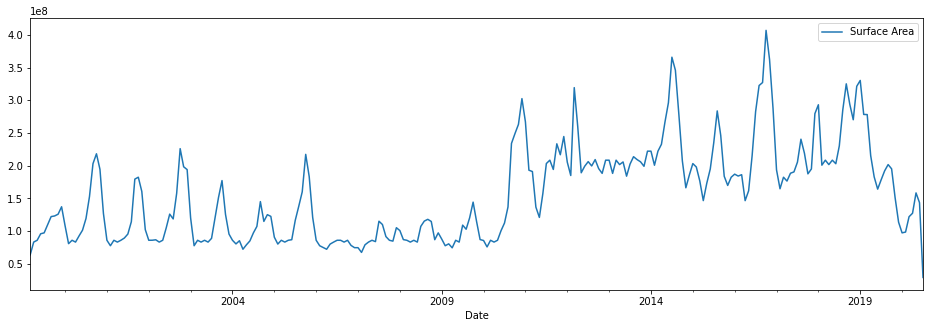

In [13]:
merged = (orig_hydrograph
          .merge(depth_to_area_df[['Surface Area', 'Depth', 'Name', 'Gauge ID']], on='Depth'))
merged = merged.sort_values(['Date'])

df1 = merged
#pd.read_csv('surface_area_timeseries.csv', parse_dates=['Date'])
df = df1.set_index(['Date'])
#Use this pandas function MS (monthly summary) to 
df = df.resample('MS').sum()
df = df.drop(columns = ['Value', 'Depth'])
df['Name'] = df1.at[0, 'Name']
df['Gauge ID'] = df1.at[0, 'Gauge ID']
df.plot(figsize=(16, 5))
print('This is a table and the graph of surface area over time (monthly). You can save this out as a csv file')
df